In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tensorflow.python.training.tracking.data_structures import NoDependency

from GenerateInput import generate_input
from LifeStepFunctions import life_step_for_tensors
from CostumisedLayers import *


In [2]:
x_train = list()
for x in product([0,1], repeat=9):
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    sample = [[x1, x2, x3], [x4, x5, x6], [x7, x8, x9]]
    x_train.append(sample)

x_train = tf.constant(np.array(x_train), dtype='float32')
y_train = life_step_for_tensors(x_train)

In [3]:
model_3x3 = tf.keras.models.Sequential()
model_3x3.add(tf.keras.layers.Flatten())
model_3x3.add(tf.keras.layers.Dense(2, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(6, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [5]:
model_3x3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

model_3x3.fit(x_train, y_train, epochs=100, batch_size=5)

Train on 512 samples
Epoch 1/100
512/512 [==============================] - 1s 2ms/sample - loss: 0.2084 - accuracy: 0.9082
Epoch 2/100
512/512 [==============================] - 0s 425us/sample - loss: 0.1990 - accuracy: 0.9395
Epoch 3/100
512/512 [==============================] - 0s 452us/sample - loss: 0.1898 - accuracy: 0.9824
Epoch 4/100
512/512 [==============================] - 0s 485us/sample - loss: 0.1810 - accuracy: 0.9941
Epoch 5/100
512/512 [==============================] - 0s 421us/sample - loss: 0.1719 - accuracy: 0.9980
Epoch 6/100
512/512 [==============================] - 0s 551us/sample - loss: 0.1634 - accuracy: 0.9980
Epoch 7/100
512/512 [==============================] - 0s 474us/sample - loss: 0.1553 - accuracy: 1.0000
Epoch 8/100
512/512 [==============================] - 0s 460us/sample - loss: 0.1489 - accuracy: 1.0000
Epoch 9/100
512/512 [==============================] - 0s 414us/sample - loss: 0.1411 - accuracy: 0.9980
Epoch 10/100
512/512 [==============

&lt;tensorflow.python.keras.callbacks.History at 0x24816c0c2c8&gt;

In [6]:
y_pred = (model_3x3.call(x_train) > 0.5)
y_pred = tf.cast(y_pred, dtype="float32")

y_pred = tf.reshape(y_pred, shape=(16,32))
y_train = tf.reshape(y_train, shape=(16,32))

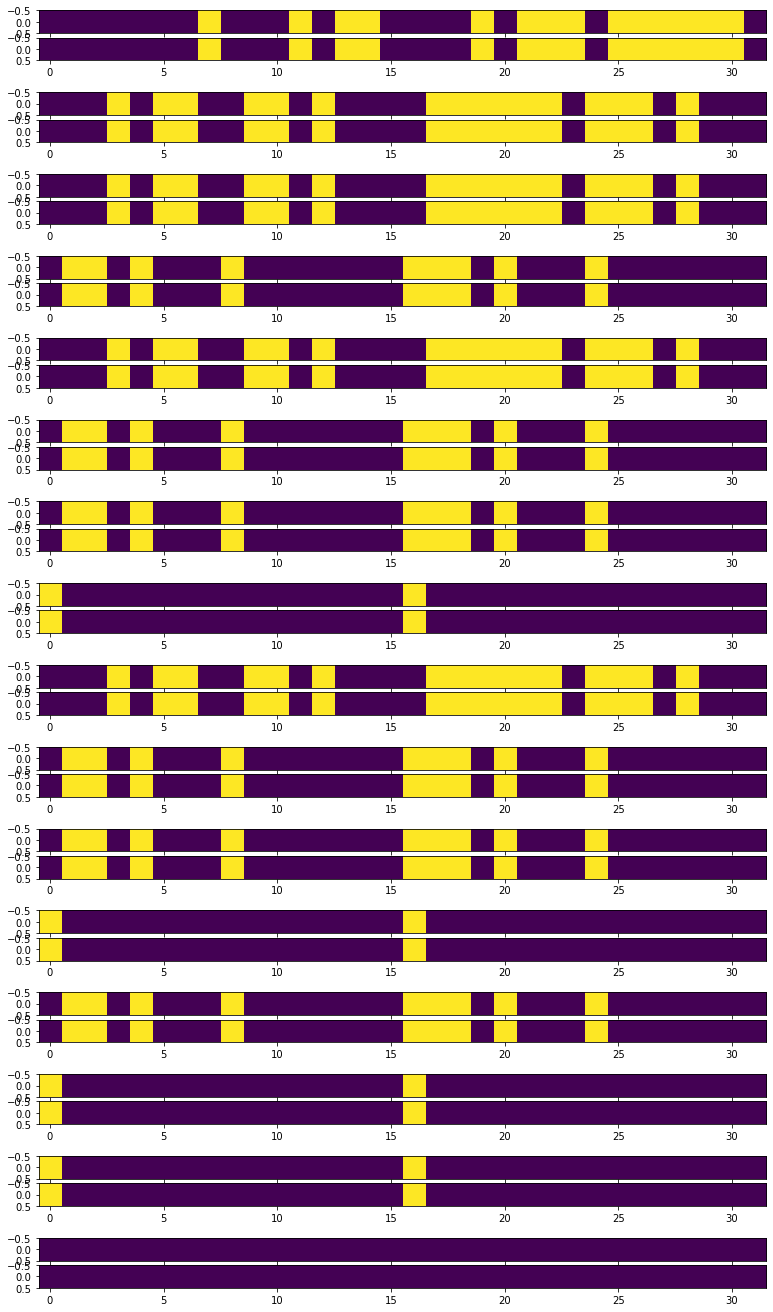

In [7]:
# checking graphically that model_3x3 has 100% accuracy

plt.figure(figsize=(16, 24))
for i in range(len(y_pred)):
    plt.subplot(48, 1, i+1 + 2*i)
    plt.imshow([y_pred[i]])
    
    plt.subplot(48, 1, i+2+ 2*(i))
    
    plt.imshow([y_train[i]])
    

In [8]:
class MyModel1(tf.keras.models.Model):
    def __init__(self, grid_size):
        super(MyModel1, self).__init__()
        self.m = grid_size[0]
        self.n = grid_size[1]

    def build(self, input_shape):
        batch_size = input_shape[0]
        self.grid = tf.Variable(tf.zeros(shape=(batch_size, self.m,self.n)), dtype='float32')

        self.grids_3x3 = NoDependency(dict())
        for i in range(self.m):
            for j in range(self.n):
                self.grids_3x3[(i,j)] = tf.Variable(tf.zeros(shape=(batch_size,3,3)), dtype='float32')


    def call(self, x):
        # find values for the cells in the interior
        for i in range(1,self.m-1):
            for j in range(1,self.n-1):
                #print(self.grids_3x3[(i,j)].shape, i, j)
                #print(x[:,i-1:i+2, j-1:j+2].shape, (i-1,i+2), (j-1,j+2))
                self.grids_3x3[(i,j)].assign(x[:,i-1:i+2, j-1:j+2])
                X = model_3x3.call(self.grids_3x3[(i,j)])
                X = tf.reshape(X, shape=(-1,1,1))
                self.grid[:,i:i+1,j:j+1].assign(X)

        # find values for the boundary cells
        for i in range(1, self.m-1):
            self.grids_3x3[(i,0)][:,:,1:].assign(x[:,i-1:i+2,:2])
            self.grids_3x3[(i,0)][:,:,0:1].assign(x[:,i-1:i+2,-1:])
            
            X = model_3x3.call(self.grids_3x3[(i,0)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,i:i+1,0:1].assign(X)
        
        for i in range(1, self.m-1):
            self.grids_3x3[(i,self.n-1)][:,:,:2].assign(x[:,i-1:i+2,-2:])
            self.grids_3x3[(i,self.n-1)][:,:,-1:].assign(x[:,i-1:i+2,0:1])
            
            X = model_3x3.call(self.grids_3x3[(i,self.n-1)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,i:i+1,-1:].assign(X)

        for j in range(1, self.n-1):
            self.grids_3x3[(0,j)][:,1:,:].assign(x[:,:2,j-1:j+2])
            self.grids_3x3[(0,j)][:,0:1,:].assign(x[:,-1:,j-1:j+2])
            
            X = model_3x3.call(self.grids_3x3[(0,j)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,0:1,j:j+1].assign(X)

        for j in range(1, self.n-1):
            self.grids_3x3[(self.m-1,j)][:,2:,:].assign(x[:,:1,j-1:j+2])
            self.grids_3x3[(self.m-1,j)][:,:2,:].assign(x[:,-2:,j-1:j+2])
            
            X = model_3x3.call(self.grids_3x3[(self.m-1,j)])
            X = tf.reshape(X, shape=(-1,1,1))
            self.grid[:,-1:,j:j+1].assign(X)

        # point (0,0)
        self.grids_3x3[(0,0)][:,1:,1:].assign(x[:,:2,:2])
        self.grids_3x3[(0,0)][:,:1,1:].assign(x[:,-1:,0:2])
        self.grids_3x3[(0,0)][:,1:,:1].assign(x[:,:2,-1:])
        self.grids_3x3[(0,0)][:,:1,:1].assign(x[:,-1:,-1:])

        X = model_3x3.call(self.grids_3x3[(0,0)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,0:1,0:1].assign(X)

        # point (0,-1)
        self.grids_3x3[(0,self.n-1)][:,1:,:2].assign(x[:,:2,-2:])
        self.grids_3x3[(0,self.n-1)][:,:1,:2].assign(x[:,-1:,-2:])
        self.grids_3x3[(0,self.n-1)][:,1:,-1:].assign(x[:,:2,:1])
        self.grids_3x3[(0,self.n-1)][:,:1,-1:].assign(x[:,-1:,0:1])
        
        X = model_3x3.call(self.grids_3x3[(0,self.n-1)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,:1,-1:].assign(X)

        # point (-1, 0)
        self.grids_3x3[(self.m-1,0)][:,:2,-2:].assign(x[:,-2:,:2])
        self.grids_3x3[(self.m-1,0)][:,:2,:1].assign(x[:,-2:,-1:])
        self.grids_3x3[(self.m-1,0)][:,2:,-2:].assign(x[:,:1,:2])
        self.grids_3x3[(self.m-1,0)][:,-1:,:1].assign(x[:,:1,-1:])
        
        X = model_3x3.call(self.grids_3x3[(self.m-1,0)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,-1:,:1].assign(X)

        # point (-1,-1)
        self.grids_3x3[(self.m-1,self.n-1)][:,:2,:2].assign(x[:,-2:,-2:])
        self.grids_3x3[(self.m-1,self.n-1)][:,:2,-1:].assign(x[:,-2:,:1])
        self.grids_3x3[(self.m-1,self.n-1)][:,-1:,:2].assign(x[:,:1,-2:])
        self.grids_3x3[(self.m-1,self.n-1)][:,-1:,-1:].assign(x[:,:1,:1])
        
        X = model_3x3.call(self.grids_3x3[(self.m-1,self.n-1)])
        X = tf.reshape(X, shape=(-1,1,1))
        self.grid[:,-1:,-1:].assign(X)
        return self.grid

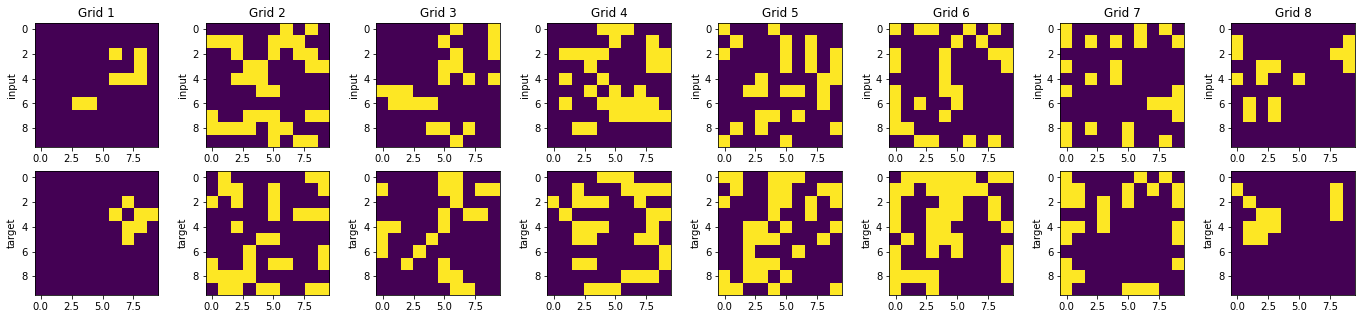

In [9]:
x, y = generate_input(trials=8, grid_shape=(10,10),steps_before_generating_output=2)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')
    

In [10]:
game = MyModel1(grid_size=(10,10))

inputs = tf.keras.layers.Input(shape=(10,10), batch_size=10)
game(inputs)

&lt;tf.Tensor &#39;my_model1/Identity:0&#39; shape=(10, 10, 10) dtype=float32&gt;

In [11]:
x0, y0 = generate_input(trials=80, grid_shape=(10,10),steps_before_generating_output=2)

y_pred = game.predict(x0[:50], batch_size=10)

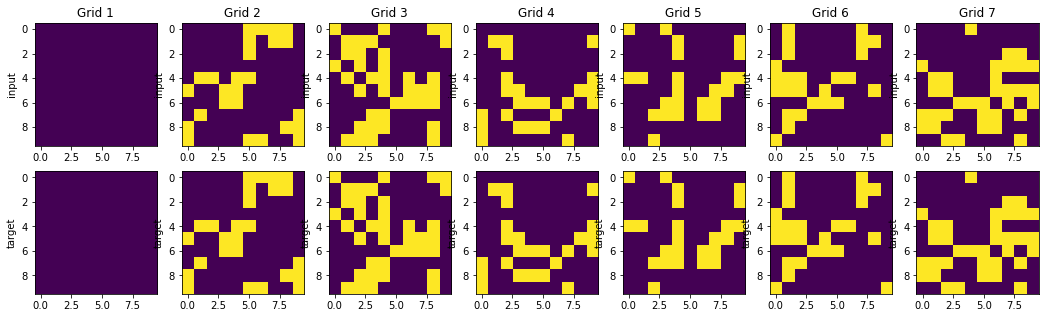

In [13]:
y = y0[:7]
y_pred0 = tf.constant(y_pred)[:7]

y_grid_pred = (y_pred0 > 0.5)
y_grid_pred = tf.cast(y_grid_pred, dtype="float32")

x = x[:6]
plt.figure(figsize=(3*len(x), 5))
for i in range(len(y)):
    plt.subplot(2, len(y), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(y_grid_pred[i])
    plt.ylabel('input')
    plt.subplot(2, len(y), len(y)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')